# load libraries

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bbknn

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

2023-04-12 07:47:45.981235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib
2023-04-12 07:47:45.981503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# stuff for R
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
# stuff for plots
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.grid']=True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titleweight']="bold"
plt.rcParams['mathtext.default']=u'regular'

# Load data

## scRNA-seq

In [4]:
data_path = '/root/host_home/data/scRNA/star/mtx_conversions/combined_matrix.h5ad'
sc_data = sc.read_h5ad(data_path)

In [5]:
sc_data.obs['sample'].head()

AAACCTGAGGGCATGT_SRX5908328    SRX5908328
AAACCTGCAGCATACT_SRX5908328    SRX5908328
AAACGGGCAATCTGCA_SRX5908328    SRX5908328
AAACGGGGTAAGTAGT_SRX5908328    SRX5908328
AAACGGGGTCTGATCA_SRX5908328    SRX5908328
Name: sample, dtype: category
Categories (10, object): ['SRX5908181', 'SRX5908302', 'SRX5908303', 'SRX5908326', ..., 'SRX5908482', 'SRX5908537', 'SRX5908538', 'SRX6785055']

In [6]:
sc_data.var.head()

,gene_symbol
DDX11L1,DDX11L1
WASH7P,WASH7P
MIR6859-1,MIR6859-1
MIR1302-2,MIR1302-2
FAM138A,FAM138A


## add meta_data

In [7]:
meta_data = '/root/host_home/data/samplesheet/samplesheet.csv'
meta_data = pd.read_csv(meta_data)
meta_data = meta_data[meta_data.description.str.contains('scRNA-seq')]
meta_data[['sample', 'sample_alias']].head()

,sample,sample_alias
0,SRX5908181,Spikein_10%
4,SRX5908302,HCC1395BL
5,SRX5908303,Spikein_5%
6,SRX5908326,Spikein_5%_Fixed_1
7,SRX5908328,Spikein_5%_Fixed_2


In [8]:
cell_type_dict = {i:j for i,j in zip(meta_data['sample'], meta_data['sample_alias'])}
sc_data.obs['sample_alias'] = [cell_type_dict[i] for i in sc_data.obs['sample']]
sc_data.obs['batch'] = sc_data.obs['sample']
sc_data.obs[['sample', 'sample_alias']].head()

,sample,sample_alias
AAACCTGAGGGCATGT_SRX5908328,SRX5908328,Spikein_5%_Fixed_2
AAACCTGCAGCATACT_SRX5908328,SRX5908328,Spikein_5%_Fixed_2
AAACGGGCAATCTGCA_SRX5908328,SRX5908328,Spikein_5%_Fixed_2
AAACGGGGTAAGTAGT_SRX5908328,SRX5908328,Spikein_5%_Fixed_2
AAACGGGGTCTGATCA_SRX5908328,SRX5908328,Spikein_5%_Fixed_2


In [9]:
sc_data.obs['sample_alias'].value_counts()

HCC1395               17027
HCC1395BL              4043
Spikein_10%            3769
Spikein_5%             3125
Spikein_5%_Fixed_1     2372
Spikein_5%_Fixed_2     1735
Name: sample_alias, dtype: int64

## normallze and batch correct

In [10]:
sc_data.obs['n_counts'] = sc_data.X.sum(1)
sc_data.obs['log_counts'] = np.log(sc_data.obs['n_counts'])
sc_data.obs['n_genes'] = (sc_data.X > 0).sum(1)

... storing 'sample_alias' as categorical


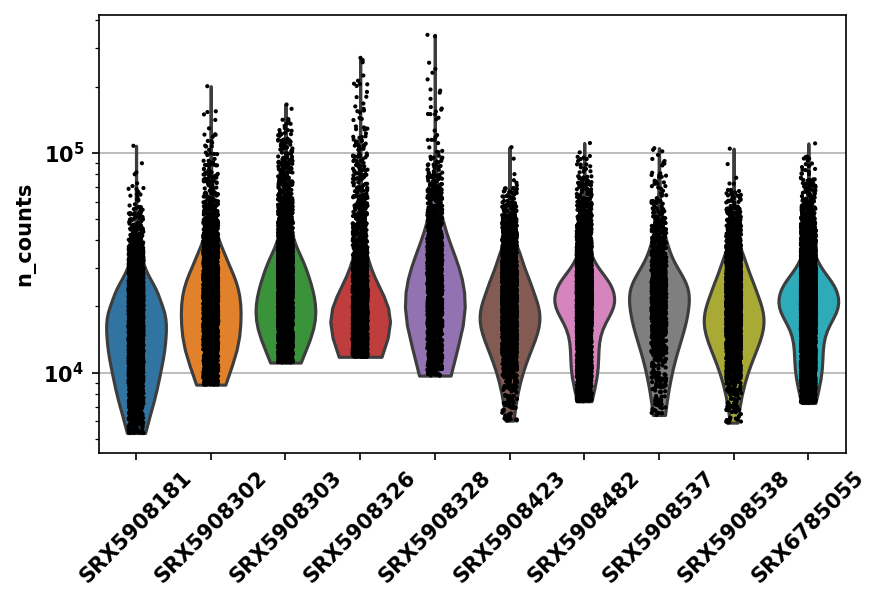

In [11]:
sc.pl.violin(sc_data, 'n_counts', groupby='sample', 
             size=2, 
             log=True, 
             cut=0, 
             rotation=45,
            )

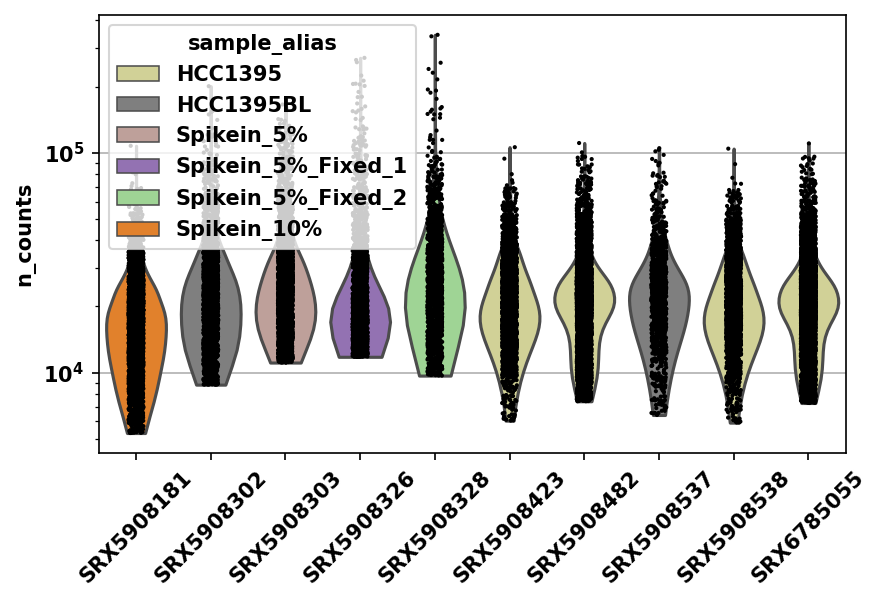

In [12]:
sc.pl.violin(sc_data, 'n_counts', groupby='sample', 
             size=2, 
             log=True, 
             cut=0, 
             rotation=45,
             palette='tab20_r',
             **{'dodge':False,
                'hue':sc_data.obs['sample_alias']}
            )

In [13]:
# one really should check fractions of mt genes,
# and gene / read ratio to exclude dead cells
# and also calculate size factors, 
# and account for cell cycle

In [14]:
old_sc_data = sc_data.copy()

In [15]:
# applying normalization used in original publication's code:
# https://github.com/oxwang/SciData_scRNAseq/

# number highly expressed genes
hvg = 2000

sc_data.raw = sc.pp.log1p(sc_data, copy=True)
sc.pp.normalize_per_cell(sc_data, counts_per_cell_after=1e5)
filter_results = sc.pp.filter_genes_dispersion(sc_data.X, n_top_genes=hvg)

sc_data = sc_data[:, filter_results.gene_subset]
sc.pp.log1p(sc_data)
sc.pp.scale(sc_data, max_value=10)

/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc_data_noBatch = sc_data.copy()

n_pcs = 30
nn = 4
sc.pp.neighbors(sc_data_noBatch, n_pcs=n_pcs, n_neighbors=nn)
#sc.tl.pca(sc_data)
sc.tl.umap(sc_data_noBatch, n_components=3)

         Falling back to preprocessing with `sc.pp.pca` and default params.


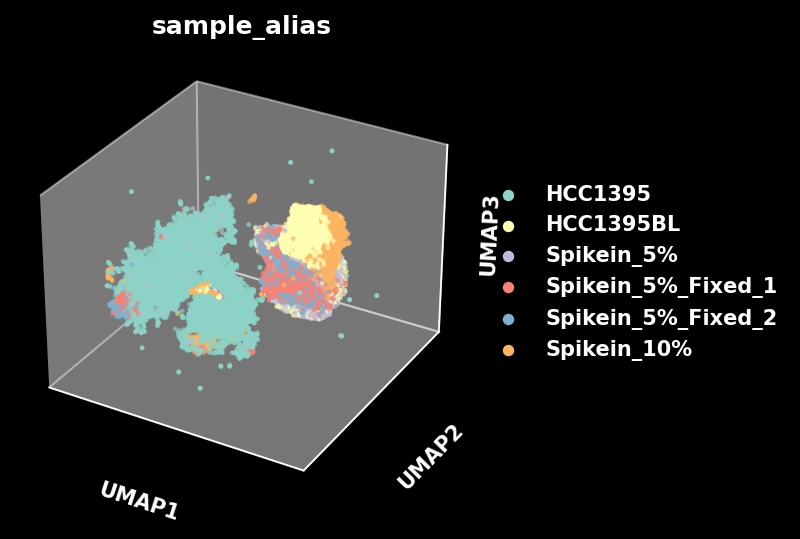

In [17]:
# plot the no batch correction UMAP
with plt.style.context('dark_background'):
    sc.pl.umap(sc_data_noBatch, color=['sample_alias'], projection='3d')

## scRNA batch correction

In [18]:
sc.tl.pca(sc_data)
sc_data.obsm['X_pca'] *= -1
sc_data = bbknn.bbknn(sc_data, neighbors_within_batch=4, 
                      n_pcs=n_pcs, 
                      trim=50,
                      copy=True)
sc.tl.umap(sc_data, n_components=3)

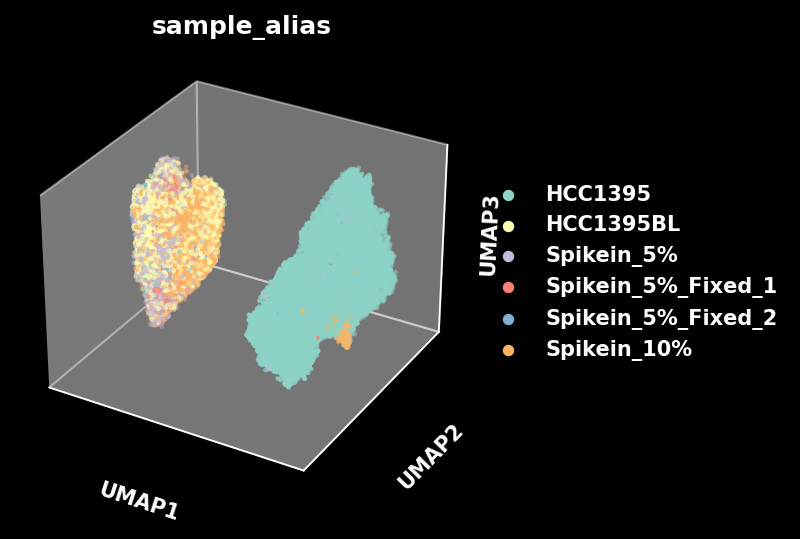

In [19]:
# this looks MUCH better
with plt.style.context('dark_background'):
    sc.pl.umap(sc_data, color=['sample_alias'], projection='3d')

## cell type grouping

In [35]:
# 'right' most group is HCC1395, 
# 'left' most group is HCC1395BL

# add that info to the anndata object
sc.tl.louvain(sc_data, key_added='louvain', resolution=0.1)

In [36]:
sc.tl.rank_genes_groups(sc_data, groupby='louvain', key_added='louvain')

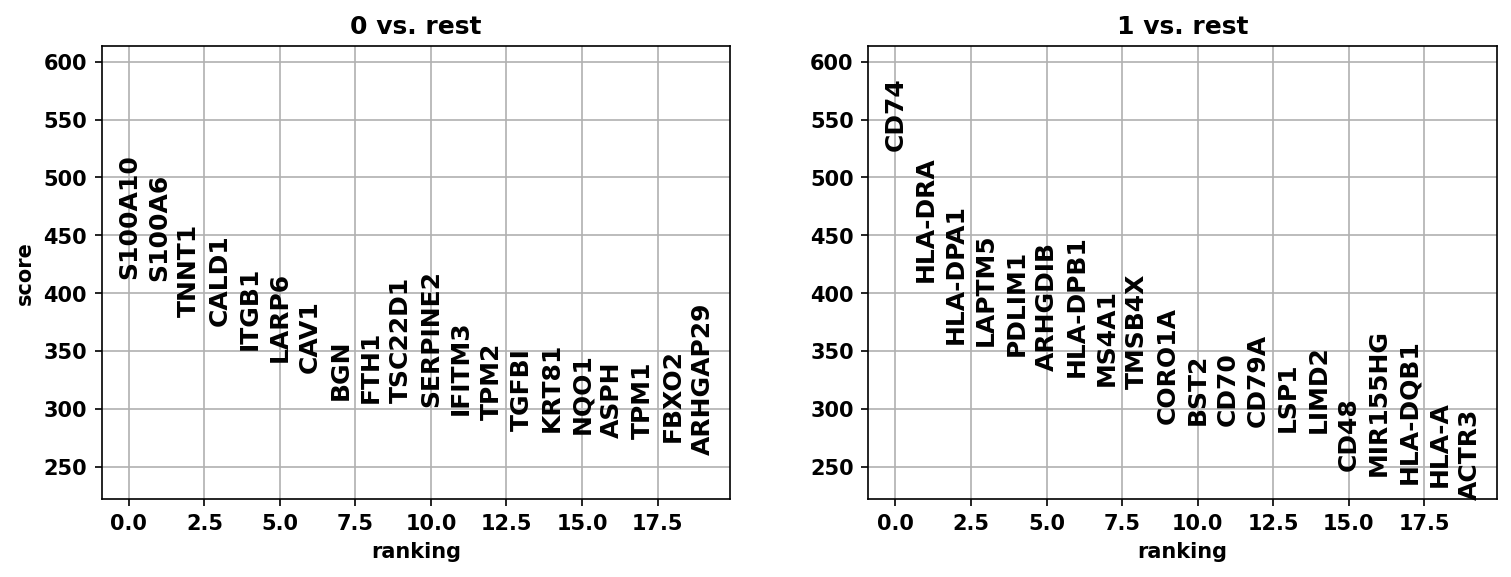

In [37]:
sc.pl.rank_genes_groups(sc_data, key='louvain', groups=['0','1'], fontsize=12)

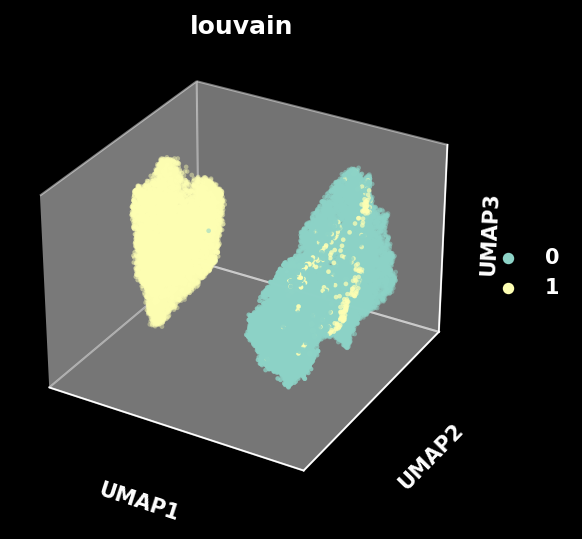

In [38]:
with plt.style.context('dark_background'):
    sc.pl.umap(sc_data, color=['louvain'], projection='3d')

In [41]:
celltype_dict = {'0': 'HCC1395', '1': 'HCC1395BL'}
sc_data.obs['cell_type'] = [celltype_dict[i] for i in sc_data.obs['louvain']]
sc_data.obs.head()

,sample,fastq_1,fastq_2,sample_alias,batch,n_counts,log_counts,n_genes,louvain,cell_type
AAACCTGAGGGCATGT_SRX5908328,SRX5908328,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,Spikein_5%_Fixed_2,SRX5908328,153912.0,11.944137,8247,1,HCC1395BL
AAACCTGCAGCATACT_SRX5908328,SRX5908328,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,Spikein_5%_Fixed_2,SRX5908328,36226.0,10.497533,5228,1,HCC1395BL
AAACGGGCAATCTGCA_SRX5908328,SRX5908328,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,Spikein_5%_Fixed_2,SRX5908328,33549.0,10.420762,4720,1,HCC1395BL
AAACGGGGTAAGTAGT_SRX5908328,SRX5908328,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,Spikein_5%_Fixed_2,SRX5908328,23327.0,10.057366,3434,1,HCC1395BL
AAACGGGGTCTGATCA_SRX5908328,SRX5908328,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,/run/media/ian/wisdom/NGS_overflow/NGS_data_st...,Spikein_5%_Fixed_2,SRX5908328,15755.0,9.664913,3042,1,HCC1395BL


In [42]:
# now save the results
sc_data.write('/root/host_home/data/scRNA/sc_data.h5ad')

... storing 'cell_type' as categorical


## Run deconvolution on bulk mRNAseq

In [25]:
#%%R

#Rscript ../R_stuff/run_deconvolution.R -r /root/host_home/data/star_salmon/deseq2_qc/deseq2.dds.RData
! Rscript ../R_stuff/run_deconvolution.R --rdata_file /root/host_home/data/star_salmon/deseq2_qc/deseq2.dds.RData --sc_data_file /root/host_home/data/scRNA/sc_data.h5ad

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package: GenomeInfoDb
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loadi